In [1]:
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf
from tensorflow.keras.layers import Embedding, Dense, Flatten
stop_words = set(stopwords.words('english'))
stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()

#### For my capstone project, I plan to create a model to classify comments into toxic and non-toxic.


#### This dataset came from kaggle and was made by collecting public comments  from the Civil Comments platform. https://www.kaggle.com/competitions/jigsaw-unintended-bias-in-toxicity-classification/data

#### The text of the individual comment is found in the comment_text column. Each comment in Train has a toxicity label (target), and models should predict the target toxicity. Target >= 0.5 will be considered to be in the positive class (toxic).

In [2]:
#import data
data = pd.read_csv('data/train.csv')
data = data[['comment_text','target']]
data['target'] = np.where(data['target']>0.5,1,0)

<Axes: ylabel='target'>

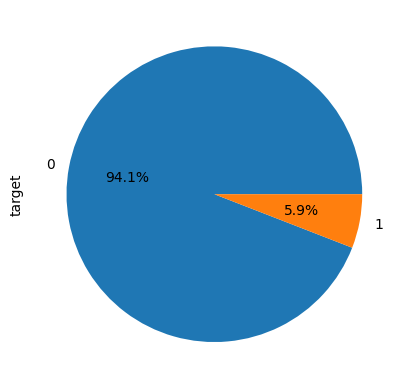

In [3]:
# check if the data is balanced
data['target'].value_counts().plot.pie(autopct = '%1.1f%%')

In [4]:
# check the number of positive and negative class
postive_data = data.query('target == 1')
negative_data = data.query('target == 0')
print(f'postive_data shape {postive_data.shape}')
print(f'negative_data shape {negative_data.shape}')

postive_data shape (106438, 2)
negative_data shape (1698436, 2)


In [5]:
# choose a portion of negative class and create a balanced dataset
negative_data_sample = negative_data.sample(frac=postive_data.shape[0]/negative_data.shape[0])


train_data = pd.concat([postive_data,negative_data_sample],axis = 0)
train_data.shape

(212876, 2)

<Axes: ylabel='target'>

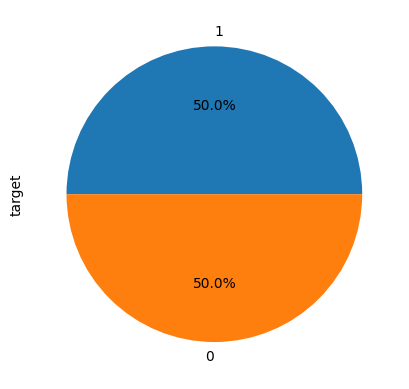

In [6]:
# check the balanced data
train_data['target'].value_counts().plot.pie(autopct = '%1.1f%%')

# Preprocess the data

In [7]:
def preprocess_text(text):
    # remove unwanted characters
    text = re.sub('[^A-Za-z]+', ' ', text)
    
    # convert to lowercase
    text = text.lower()
    
    # tokenize the text into words
    words = word_tokenize(text)
    
    # remove stopwords
    words = [word for word in words if word not in stop_words]
    
    # stem the words
    stemmed_words = [stemmer.stem(word) for word in words]
    
    # lemmatize the words
    lemmatized_words = [lemmatizer.lemmatize(word) for word in stemmed_words]
    
    # join the words back into a string
    text = ' '.join(lemmatized_words)
    
    return text

In [8]:
# preposs the data
train_data_t = train_data.sample(frac = 0.1)
X = train_data_t['comment_text'].apply(preprocess_text)
y = train_data_t['target']

In [9]:
from sklearn.feature_extraction.text import TfidfVectorizer
train_features,val_features,train_labels,val_labels = train_test_split(X,y,test_size=0.2)

# initialize the TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer()

# fit the TfidfVectorizer on the train data
tfidf_vectorizer.fit(train_features)

# transform the text in the train and test data into feature vectors
train_features = tfidf_vectorizer.transform(train_features)
val_features = tfidf_vectorizer.transform(val_features)

In [10]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
# create a function to evaludate the 
def evaluate(model, val_features, val_labels):
    preds = model.predict(val_features)
    acc = accuracy_score(val_labels, preds)
    prec = precision_score(val_labels, preds)
    recall = recall_score(val_labels, preds)
    f1 = f1_score(val_labels, preds)
    return acc, prec, recall, f1

# Train and evaluate logistic regression, naive Bayes, random forest, and SVM models

In [11]:
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
# Train and evaluate a logistic regression model
lr = LogisticRegression()
lr.fit(train_features, train_labels)
lr_eval = evaluate(lr, val_features, val_labels)

# Train and evaluate a Naive Bayes model
nb = MultinomialNB()
nb.fit(train_features, train_labels)
nb_eval = evaluate(nb, val_features, val_labels)

# Train and evaluate a random forest model
rf = RandomForestClassifier(n_estimators=100)
rf.fit(train_features, train_labels)
rf_eval = evaluate(rf, val_features, val_labels)

# Train and evaluate an SVM model
svm = SVC(kernel='linear')
svm.fit(train_features, train_labels)
svm_eval = evaluate(svm, val_features, val_labels)

In [12]:
result = pd.DataFrame(np.array([lr_eval,nb_eval,rf_eval,svm_eval]),
                      columns=['Accuracy','Precision','Recall','F1'],
                      index = ['Logistic regression','Naive Bayes','Random forest','Svm'])
result


,Accuracy,Precision,Recall,F1
Logistic regression,0.847816,0.879004,0.808322,0.842182
Naive Bayes,0.795914,0.774654,0.837307,0.804763
Random forest,0.846876,0.863214,0.826087,0.844243
Svm,0.859558,0.877511,0.837307,0.856938


# Neural network

In [13]:
# preposs the data
train_data_n = train_data.sample(frac = 1)
X = train_data_n['comment_text'].apply(preprocess_text)
y = train_data_n['target']

In [14]:
from tensorflow.keras.layers import Embedding, Dense, Flatten

# split the data into train and validation sets
train_text, val_text, train_target, val_target = train_test_split(X,y, test_size=0.2, random_state=42, stratify=y)

# tokenize the text and convert it to sequences
tokenizer = Tokenizer(num_words=10000)
tokenizer.fit_on_texts(train_text)
train_seq = tokenizer.texts_to_sequences(train_text)
val_seq = tokenizer.texts_to_sequences(val_text)

# calculate the averge comment length
length = [len(x) for x in train_seq]
print('mean length',np.mean(length))
print('min length',np.min(length))
print('max length',np.max(length))

mean length 24.01027011156782
min length 0
max length 304


In [18]:
 # calculate the accuracy of each class
def postive_class(prediction,y_test):
    prediction = prediction.reshape(-1,1)
    pos_index = y_test == 1
    neg_index = y_test == 0
    pos_acc = sum(prediction[pos_index])/y_test[pos_index].shape[0]
    neg_acc = 1 - sum(prediction[neg_index])/y_test[neg_index].shape[0]
    return pos_acc,neg_acc

In [20]:
# pad the sequences so they all have the same length
maxlen = 100
train_seq = pad_sequences(train_seq, maxlen=maxlen)
val_seq = pad_sequences(val_seq, maxlen=maxlen)
# create a nueral network model

with tf.device('/GPU:0'):
    model = Sequential()
    model.add(Embedding(input_dim=10000, output_dim=32, input_length=maxlen))
    model.add(Flatten())
    model.add(Dense(100,activation= 'relu'))
    model.add(Dense(1, activation='sigmoid'))

    # compile the model 
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

    # set up early stopping to prevent overfitting
    early_stopping = EarlyStopping(monitor='val_loss', patience=2)

    # train the model
    history = model.fit(train_seq, train_target, validation_data=(val_seq, val_target), epochs=10, batch_size=64, verbose = 1,callbacks=[early_stopping])
   

    prediction = model.predict(val_seq)
    prediction = np.where(prediction>0.5,1,0).reshape(-1)
    result = postive_class(prediction,val_target)  
print(f'positive class accuracy: {result[0]}')
print(f'negative class accuracy: {result[1]}')

Epoch 1/10
2661/2661 [==============================] - 5s 2ms/step - loss: 0.3317 - accuracy: 0.8546 - val_loss: 0.2781 - val_accuracy: 0.8855
Epoch 2/10
2661/2661 [==============================] - 5s 2ms/step - loss: 0.2247 - accuracy: 0.9127 - val_loss: 0.2968 - val_accuracy: 0.8814
Epoch 3/10
2661/2661 [==============================] - 5s 2ms/step - loss: 0.1425 - accuracy: 0.9473 - val_loss: 0.3803 - val_accuracy: 0.8730
positive class accuracy: [0.86480646]
negative class accuracy: [0.8811537]


# CNN

In [21]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, Conv1D, GlobalMaxPooling1D, Dropout

model = Sequential()
model.add(Embedding(input_dim=10000, output_dim=32, input_length=100))
model.add(Conv1D(filters=32, kernel_size=5, activation='relu'))
model.add(Conv1D(filters=64, kernel_size=5, activation='relu'))
model.add(Conv1D(filters=128, kernel_size=5, activation='relu'))
model.add(GlobalMaxPooling1D())
model.add(Dense(units=64, activation='relu'))
model.add(Dense(units=1, activation='sigmoid'))


model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
history = model.fit(train_seq, train_target, validation_data=(val_seq, val_target), epochs=10, batch_size=64, verbose = 1,callbacks=[early_stopping])
prediction = model.predict(val_seq)
prediction = np.where(prediction>0.5,1,0).reshape(-1)
result = postive_class(prediction,val_target)  
print(f'positive class accuracy: {result[0]}')
print(f'negative class accuracy: {result[1]}')

Epoch 1/10
2661/2661 [==============================] - 14s 3ms/step - loss: 0.3128 - accuracy: 0.8624 - val_loss: 0.2658 - val_accuracy: 0.8910
Epoch 2/10
2661/2661 [==============================] - 7s 3ms/step - loss: 0.2443 - accuracy: 0.9018 - val_loss: 0.2652 - val_accuracy: 0.8920
Epoch 3/10
2661/2661 [==============================] - 7s 3ms/step - loss: 0.2008 - accuracy: 0.9218 - val_loss: 0.2819 - val_accuracy: 0.8866
Epoch 4/10
2661/2661 [==============================] - 7s 3ms/step - loss: 0.1532 - accuracy: 0.9423 - val_loss: 0.3177 - val_accuracy: 0.8795
positive class accuracy: [0.89928598]
negative class accuracy: [0.85968621]


# LSTM

In [23]:
with tf.device('/GPU:0'):
    model = Sequential()
    model.add(Embedding(input_dim=10000, output_dim=128, input_length=100))
    model.add(LSTM(64, dropout=0.2,return_sequences=True))
    model.add(LSTM(32, dropout=0.2))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))

    # compile the model
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

    # train the model
    history = model.fit(train_seq, train_target, validation_data=(val_seq, val_target), epochs=10, batch_size=64, verbose = 1,callbacks=[early_stopping])

prediction = model.predict(val_seq)
prediction = np.where(prediction>0.5,1,0).reshape(-1)
result = postive_class(prediction,val_target)  
print(f'positive class accuracy: {result[0]}')
print(f'negative class accuracy: {result[1]}')

Epoch 1/10
2661/2661 [==============================] - 32s 11ms/step - loss: 0.3107 - accuracy: 0.8732 - val_loss: 0.2635 - val_accuracy: 0.8928
Epoch 2/10
2661/2661 [==============================] - 32s 12ms/step - loss: 0.2561 - accuracy: 0.9008 - val_loss: 0.2590 - val_accuracy: 0.8948
Epoch 3/10
2661/2661 [==============================] - 33s 12ms/step - loss: 0.2345 - accuracy: 0.9093 - val_loss: 0.2661 - val_accuracy: 0.8924
Epoch 4/10
2661/2661 [==============================] - 40s 15ms/step - loss: 0.2093 - accuracy: 0.9194 - val_loss: 0.2787 - val_accuracy: 0.8893
positive class accuracy: [0.90567456]
negative class accuracy: [0.87298008]


In [26]:
train_acc = [0.947,0.9423,0.9194]
val_acc = [0.8730,0.8795,0.8893]
postive_val = [0.8648,0.8992,0.9056]
negative_val = [0.8811,0.8596,0.8729]
result_nn = pd.DataFrame({'train accuracy':train_acc,'val accuracy':val_acc,'postive class':postive_val,'negative_class':negative_val},index = ['Neural network','CNN','LSTM'])
result_nn

,train accuracy,val accuracy,postive class,negative_class
Neural network,0.9470,0.8730,0.8648,0.8811
CNN,0.9423,0.8795,0.8992,0.8596
LSTM,0.9194,0.8893,0.9056,0.8729
